# 

# Project 1: Navigation
## Udacity Deep Reinforcement Learning Nano-Degree

The goal of this project is to use the Deep Q-Learning algorithm to train an agent to solve the Unity Banana environment. The Unity Banana environment is a simple 3d environment consisting of a bounding box, and a number of blue and yellow bananas. A successful agent moves around collecting only the yellow bananas avoiding the blue ones.

For the purpose of this assignment, the task is considered solved when the agent can get an average score of +13 over 100 consecutive episodes.

## Banana Environment

### Actions

At any time, the agent can take one of four actions:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

### States

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.

### Rewards

A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana.

## Implementation Details

For this project, I used the basic Deep Q-Learning algorithm presented in the earlier coding exercise. For the basic structure of the neural network, and the dqn agent, I used the code provided in the [solution to the earlier exercise](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn/solution).

I modified the training routine to work with the Unity environment's API format, and I modified the parameters of the training function, dgn agent, and neural network so I could conduct a hyperparmeter search using scikit-optimize.

### Project Structure

- [model.py](model.py) - defines the structure of the q-network using PyTorch
- [dqn_agent.py](dqn_agent.py) - defines the agent implementation including the learning step
- [train.py](train.py) - defines the training loop to run a training sequence with a given set of hyperparameters
- [optimize.py](optimize.py) - defines an optimization routine to search for optimal hyperparameters
- [Report.ipynb](Report.ipynb) - defines the solution steps, algorithm and outputs from different training and optimiztion runs
- [checkpoint_base_model.pth](checkpoint_base_model.pth) - the saved model weights from the initial parameter choices 
- [checkpoint_optimal_model.pth](checkpoint_optimal_model.pth) - the saved model weights from the initial parameter choices
- [playing.gif](playing.gif) - a gif of the trained optimal agent playing
- [environment.yml](environment.yml) - the conda environment file for reproducing the experiment

In [1]:
from train import dqn
from optimize import find_optimal_hyperparameters
import matplotlib.pyplot as plt
%matplotlib inline
import json
from unityagents import UnityEnvironment
import numpy as np
from skopt.plots import plot_convergence

# initialize the environment and brain
env = UnityEnvironment(file_name="env/Banana.app")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Get the action and state size from the environment
env_info = env.reset(train_mode=True)[brain_name]
ACTION_SIZE = brain.vector_action_space_size
state = env_info.vector_observations[0]
STATE_SIZE = len(state)

print(f"State Size: {ACTION_SIZE}, Action Size: {STATE_SIZE}")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


State Size: 4, Action Size: 37


In [2]:
def plot_scores(scores):
    ## Plot the scoring results
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

## Starting Point

As a benchmark, I did a full training run using the parameters set in the initial implementation above. The results are below.

{
  "tau": 0.001,
  "gamma": 0.99,
  "lr": 0.0005,
  "fc2_units": 64,
  "fc1_units": 64,
  "update_every": 4,
  "batch_size": 64,
  "eps_decay": 0.995,
  "eps_end": 0.01,
  "eps_start": 1.0,
  "max_t": 1000,
  "n_episodes": 1800,
  "solved_threshold": 13.0,
  "break_early": true,
  "name": "_base_model",
  "action_size": 4,
  "state_size": 37,
  "brain_name": "BananaBrain"
Episode 477	Average Score: 13.02
Environment solved in 477 episodes!	Average Score: 13.02


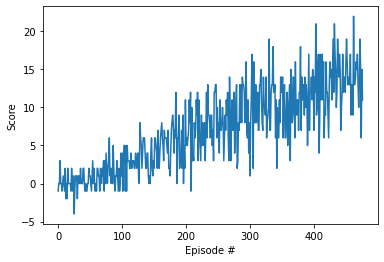

In [7]:
scores = dqn(env=env, brain_name=brain_name, name="_base_model", n_episodes=1800, break_early=True)

plot_scores(scores)

I was suprised to see a good result just with this base implementation not tuned to this environent. It solved the problem much faster than the 1800 episodes suggested in the assignment documentation.

## Find Optimal Hyperparameters

Because each training run is expensive, something like a grid search that isn't "smart" is not an ideal way to search for hyperparamters. I instead used the `scikit-optimize` package which implements bayesian hyperparameter optimization using gaussian process regression.

In the file [optimize.py](optimize.py) I defined a paramater search over a number of parameters and defined a function to find optimal hyperparameters.

```python
# define the search space for bayesian optimization
space = [Integer(32,64, name="batch_size"),
          Integer(2, 10, name="update_every"),
          Integer(32, 128, name="fc1_units"),
          Integer(32, 128, name="fc2_units"),
          Real(1e-5, 1e0, "log-uniform", name='eps_decay'),
          Real(1e-5, 1e0, "log-uniform", name='lr'),
          Real(1e-5, 1e0, "log-uniform", name="gamma"),
          Real(1e-5, 1e0, "log-uniform", name="tau")
        ]
```

To save time, I limited the number of episodes to 200 for each attempt during the hyperparameter search. My thinking here is that while the task won't be solved in 200 episodes, that should be enough to give a signal in terms of the best hyperparameters.

In [3]:
optimal_params, res_gp, = find_optimal_hyperparameters(env=env, brain_name=brain_name)
plot_convergence(res_gp)

{
  "tau": 1.921165975741198e-05,
  "gamma": 0.0003073781785362612,
  "lr": 0.0008354270566129826,
  "fc2_units": "113",
  "fc1_units": "114",
  "update_every": "9",
  "batch_size": "51",
  "eps_decay": 0.013116515715358098,
  "eps_end": 0.01,
  "eps_start": 1.0,
  "max_t": 1000,
  "n_episodes": 200,
  "solved_threshold": 13.0,
  "break_early": false,
  "name": "",
  "action_size": 4,
  "state_size": 37,
  "brain_name": "BananaBrain"
Episode 200	Average Score: 0.1{2
  "tau": 0.017412429067220004,
  "gamma": 0.0004863857046189474,
  "lr": 0.15149343663386153,
  "fc2_units": "78",
  "fc1_units": "110",
  "update_every": "6",
  "batch_size": "41",
  "eps_decay": 0.0009202884691104562,
  "eps_end": 0.01,
  "eps_start": 1.0,
  "max_t": 1000,
  "n_episodes": 200,
  "solved_threshold": 13.0,
  "break_early": false,
  "name": "",
  "action_size": 4,
  "state_size": 37,
  "brain_name": "BananaBrain"
Episode 200	Average Score: -0.01{
  "tau": 0.02479691484362036,
  "gamma": 0.004003016661601729,

We can see from the convergence plot that after 22 episodes the improvement in performance stabilized.

### Full Training Run with Optimized Parameters

After finding optimal parameters using the search above, I conducted a full training run using the new parameters.

In [6]:
scores = dqn(
    env=env, 
    brain_name=brain_name, 
    name="_optimal_model",
    **optimal_params
)

plot_scores(scores)

{
  "tau": 3.8801065755411095e-05,
  "gamma": 1.0,
  "lr": 5.288386055674643e-05,
  "fc2_units": 111,
  "fc1_units": 115,
  "update_every": 2,
  "batch_size": 57,
  "eps_decay": 0,
  "eps_end": 0.01,
  "eps_start": 1.0,
  "max_t": 1000,
  "n_episodes": 1800,
  "solved_threshold": 13.0,
  "break_early": true,
  "name": "_optimal_model",
  "action_size": 4,
  "state_size": 37,
  "brain_name": "BananaBrain"
Episode 223	Average Score: 13.08
Environment solved in 223 episodes!	Average Score: 13.0


So, after optimizing the hyperparameters, the agent solves this task in only 223 episodes compared with 477 episodes, which is a pretty significant improvement. However, looking at the score plot the results appear less stable with much larger variance between scores on different episodes.

## Watched the trained agent play!

In [12]:
from dqn_agent import Agent
import torch
import time

agent = Agent(
    state_size=37, action_size=4, seed=0, 
    fc1_units=optimal_params["fc1_units"], fc2_units=optimal_params["fc2_units"])

# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_optimal_model.pth'))

for i in range(10):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    for j in range(200):
        action = agent.act(state)
        env_info = env.step(action)[brain_name]
        state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        time.sleep(0.05)
        if done:
            break

![playing.gif](playing.gif)

# Next Steps

At this point I have used the basic DQN algorithm, and optimized the hyperparameters. The next step to improve the performance of an agent on this task would be to use one of the improvements on basic DQN such as double DQN, dueling DQN, and/or prioritized experience replay.